In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *

In [14]:
def bke_legend():
    legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)

In [15]:
data = pd.read_csv("../data/accel_rotate_on_bench.csv")

In [16]:
data.head()

,loops_per_sec,micros_per_loop,quat_w,quat_x,quat_y,quat_z,areal_x,areal_y,areal_z,aworld_x,aworld_y,aworld_z
0,20265,49.35,0.68,0.05,-0.73,0.01,3565,239,-221,-35,20,3579
1,91640,10.91,0.68,0.05,-0.73,0.02,3570,275,-191,-106,89,3583
2,91647,10.91,0.68,0.06,-0.73,0.02,3575,301,-177,-143,128,3586
3,91651,10.91,0.68,0.06,-0.73,0.03,3575,307,-168,-161,139,3585
4,91649,10.91,0.67,0.06,-0.74,0.03,3566,326,-201,-140,164,3580


[]

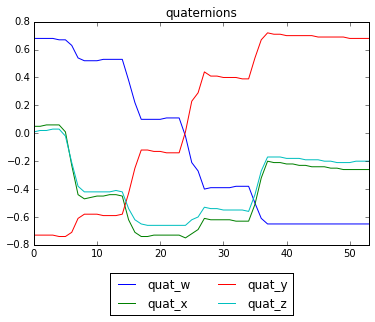

In [17]:
data.quat_w.plot()
data.quat_x.plot()
data.quat_y.plot()
data.quat_z.plot()
legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
title('quaternions')
plot()

[]

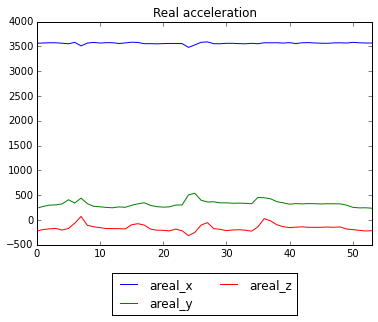

In [18]:
data.areal_x.plot()
data.areal_y.plot()
data.areal_z.plot()
title('Real acceleration')
bke_legend()

plot()

In [19]:

def quat_angle(q1, q2):
    return math.acos(2.* (quat_dot(q1,q2)**2.0) - 1.);

def quat_dot(q1, q2):
    return q1.w*q2.w + q1.x*q2.x +q1.y*q2.y + q1.z*q2.z

def quat_mul(q1, q2):
    x = q1.w*q2.x + q1.x*q2.w + q1.y*q2.z - q1.z*q2.y;
    y = q1.w*q2.y + q1.y*q2.w + q1.z*q2.x - q1.x*q2.z;
    z = q1.w*q2.z + q1.z*q2.w + q1.x*q2.y - q1.y*q2.x;
    w = q1.w*q2.w - q1.x*q2.x - q1.y*q2.y - q1.z*q2.z;
    return quaternion(w,x,y,z);

def normalize(v):
    return v/np.linalg.norm(v)

# project v onto normal n
def project(v,n):
    return v - np.array(v)*np.dot(v,n) / np.linalg.norm(n)

def degrees(radians):
    return radians * 180. / math.pi;


class quaternion:
    def __init__(self,w=1,x=0.,y=0.,z=0.):
        self.w = w
        self.x = x
        self.y = y
        self.z = z
        self._normalize()
        
    def __repr__(self):
        return '({0},{1},{2},{3})'.format(self.w,self.x,self.y,self.z)
    
    def dot(self, q2):
        return quat_dot(self,q2)
    
    def angle(self,q2):
        return quat_angle(self,q2)
    
    def mul(self, q2):
        return quat_mul(self,q2)
    
    def vmul(self,v):
        q2 = quaternion(0.0,v[0],v[1],v[2])
        q1 = self
        rv = quat_mul(quat_mul(q1, q2), q1.conjugate())
        return [rv.x,rv.y,rv.z]
    
    def inverse(self):
        return self.conjugate()._normalize();
    
    def diff(self, q2):
        return self.inverse().mul(q2)
    
    def div(self, q2):
        return quat_mul(self,q2.conjugate())
    
    def conjugate(self):
        return quaternion(self.w,-self.x,-self.y,-self.z)
    
    def _magnitude(self):
        return math.sqrt(self.w*self.w+self.x*self.x+self.y*self.y+self.z*self.z);
    
    def _normalize(self):
        m = self._magnitude()
        self.w = self.w/m
        self.x = self.x/m
        self.y = self.y/m
        self.z = self.z/m
        return self

In [20]:
q0 = quaternion(1,0,0,0)
q1 = quaternion(0,1,0,0)

In [21]:
print q0.angle(q0)
print degrees(q0.angle(q1))
print q1.dot(q1)

0.0
180.0
1.0


In [22]:
quats = [quaternion(x['quat_w'], x['quat_x'], x['quat_y'], x['quat_z']) for index,x in data.iterrows()]


In [23]:
# return angle quaternion q rotates about unit normal vector n
def normal_angle(q,n):
    # find unit vector normal to n to make our x axis
    # todo: make sure it isn't parallel
    vx = normalize(project([1.,1.,1.],n))

    # find unit vector orthogonal to vx and n to make our y axis
    vy = np.cross(n,vx)

    # rotate it
    rotx = q.vmul(vx)
    #print(rotx)

    # project onto plane
    rotx = project(rotx,n)
    
    # express in terms of vx,vy
    x,y = normalize([np.dot(vx,rotx), np.dot(vy,rotx)])
    
    #print ('x: {0} y:{1}'.format(x,y))
    
    # return angle
    return math.atan2(y,x)


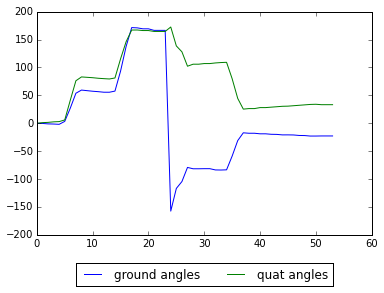

In [24]:
g=normalize([1.0,0.01,0.02])
angles = [degrees(normal_angle(q.diff(quats[0]),g)) for q in quats]
quat_angles = [degrees(q.angle(quats[0])) for q in quats]
plot(angles, label='ground angles')
plot(quat_angles, label = 'quat angles')
bke_legend()
